In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import GridSearchCV, StratifiedKFold


from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc, confusion_matrix, roc_auc_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC

from typing import Iterable, List, Tuple, Union
from collections import Counter
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 6.5)

In [2]:
breast_cancer = load_breast_cancer()
X = pd.DataFrame(data=breast_cancer["data"], columns=breast_cancer["feature_names"])

# добавим искуственный категориальный признак
X['mean area cat'] = pd.qcut(X['mean area'], 5, labels=['smallest','small','medium','big', 'largest']).astype('object') 

X["target"] = breast_cancer["target"]
X_train, X_test = train_test_split(X, test_size=0.25, random_state=42)
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,mean area cat,target
287,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915,medium,1
512,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,...,113.30,844.4,0.15740,0.3856,0.5106,0.20510,0.3585,0.11090,medium,0
402,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,...,96.31,621.9,0.09329,0.2318,0.1604,0.06608,0.3207,0.07247,medium,1
446,17.75,28.03,117.30,981.6,0.09997,0.13140,0.16980,0.08293,0.1713,0.05916,...,145.40,1437.0,0.14010,0.3762,0.6399,0.19700,0.2972,0.09075,largest,0
210,20.58,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,0.05024,...,158.30,1656.0,0.11780,0.2920,0.3861,0.19200,0.2909,0.05865,largest,0


In [3]:
def split_node(R_m: np.ndarray, feature: str, t: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Split a fixed set of objects R_m with given feature name and threshold t
    """
    mask = R_m[feature] <= t
    R_l = R_m.loc[mask]
    R_r = R_m.loc[~mask]
    return R_l, R_r


def q_error(R_m: np.ndarray, feature: str, t: float) -> float:
    """
    Compute error criterion for the given objects R_m, feature name and threshold t
    """
    R_l, R_r = split_node(R_m, feature, t)
    return  len(R_l) / len(R_m) * H(R_l['target']) + len(R_r) / len(R_m) * H(R_r['target'])

In [4]:
def H(y: np.ndarray) -> float:
    """
    Compute entropy for vector y with classes of objects R
        
    """
    y = list(y)

    if len(y) == 0:
      return 0

    p0, p1 = y.count(0)/len(y), y.count(1)/ len(y)
    #print(p0, p1)

    if p0*p1 != 0:
      entropy = -p0*np.log2(p0) - p1*np.log2(p1)
    else:
      entropy = 1/float("+inf")

    return entropy

print(H([0,0,0,0,0,1]))
print(H([0,0,0,0,0,0]))

# Проверяем на простых примерах
assert np.isclose(H([0,0,0,0,0,1]), 0.650022)
assert np.isclose(H([0,0,0,0,0,0]), 0)

0.6500224216483541
0.0


In [5]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    """
    Find best split of objects R_m by feature and return minimal q_error (opt_q_error), best threshold (opt_threshold) and array of error criterions (Q_array)
        
    """
    Q_array = []
    unique_t = np.unique(sorted(R_m[feature]))

    feature_values = (unique_t[1:] + unique_t[:-1])/2

    #В качестве порога использовалось среднее двух различных соседних (при сортировке) значений признака
      # это сразу гарантирует, что не будет 0 значений (только если входной массив не нулевой/единичный)
    
    opt_q_error = 1

    if len(R_m) == 0:
      return None, None, None

    for i in range(len(feature_values)):
      
      t = feature_values[i]
      qerror = q_error(R_m, feature, t)
      Q_array.append(qerror)
      
    Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
    
    minimum_id = np.argmin(Q_array)
    opt_threshold = feature_values[minimum_id]
    opt_q_error = Q_array[minimum_id]

    return opt_threshold, opt_q_error, Q_array

Выберем признак и посмотрим на значение критерия информативности

In [6]:
my_feature, tt = 'worst area', 800

print('Значение кр.инф. до разбиения {}'.format(H(X['target'])))
print('Значение кр.инф. после разбиения {}'.format(q_error(X, my_feature, tt)))

Значение кр.инф. до разбиения 0.9526351224018599
Значение кр.инф. после разбиения 0.45763197043007536


График зависимости критерия ошибки от выбранного порога для выбранного признака с точкой минимума.

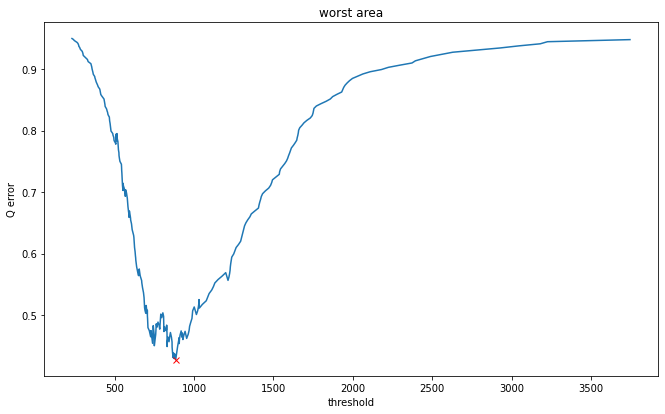

In [7]:
t, q_err, Q_array = get_optimal_split(X_train, my_feature)
t_uniqs = sorted(np.unique(X_train[my_feature]))

plt.plot([(t_uniqs[i]+t_uniqs[i+1])/2 for i in range(len(t_uniqs[:-1]))], Q_array)
plt.title(my_feature)
plt.xlabel("threshold")
plt.ylabel("Q error")
plt.plot(t, q_err, 'rx')

plt.show()


### Признак с минимальным значением критерия ошибки.

In [8]:
qqs = 1
list_f_t_q = []
optimal_feature = 'target'
optimal_t = None
cols = np.array(X.columns.drop(['mean area cat', 'target']))
for feat in cols:
  thr, qq, QQ = get_optimal_split(X_train, feat)
  list_f_t_q.append((feat,thr, qq))
  # полагаю, это работает дольше, так что спрячем пока 
  """if qq < qqs:
    qqs = qq
    optimal_feature = feat
    optimal_t = thr"""
list_f_t_q.sort(key=lambda x: x[2])
best_ftq = list_f_t_q[0]
optimal_feature, optimal_t, qqs =  best_ftq[0],best_ftq[1],best_ftq[2]   

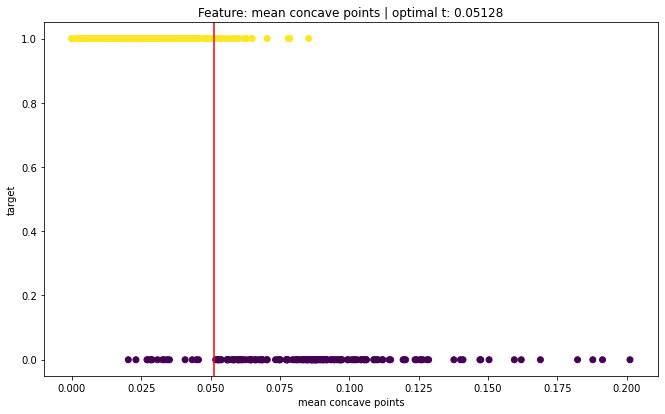

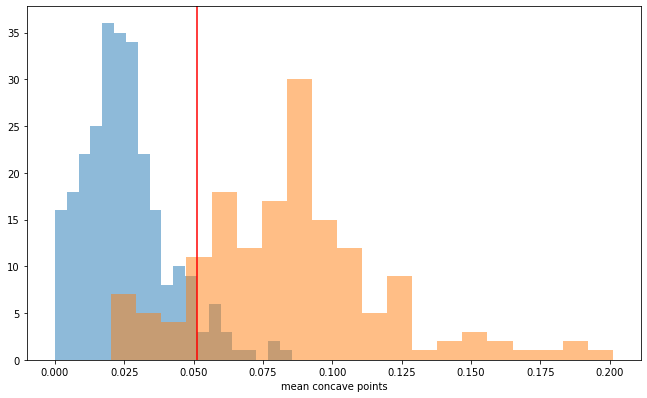

In [9]:
plt.scatter(X_train[optimal_feature], X_train['target'], c=X_train['target'])
plt.axvline(x=optimal_t, color="red")
plt.xlabel(optimal_feature)
plt.ylabel("target")
plt.title("Feature: {} | optimal t: {}".format(optimal_feature, optimal_t))
plt.show()

plt.xlabel(optimal_feature)
plt.axvline(x=optimal_t, color="red")
plt.hist(X_train[optimal_feature][X_train['target']==1], bins=20, alpha=0.5)
plt.hist(X_train[optimal_feature][X_train['target']==0], bins=20, alpha=0.5)
plt.show()

## Реализация дерева решений

In [10]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None
    ) -> None:
        
        if np.any(list(map(lambda x: x not in ('int64', 'float64', 'object'), feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой ("terminal" или "nonterminal"). Листовые вершины хранят значение класса для предсказания, 
        # нелистовые - правого и левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {"depth":0}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

# смотрим на последовательность вершин дерева
        self.feature_sequense = []

    def _fit_node(
        self, 
        sub: pd.DataFrame, # подмножество объектов для данной вершины
        node: dict        # словарь для хранения информации о вершине
    ) -> None:
        
        # критерий остановки - проверяем что не все классы объектов в данной вершине одинаковы
        if np.all(sub['target'] == sub['target'].iloc[0]):
            node["type"] = "terminal"
            node["class"] = sub['target'].iloc[0]
            return
        
        if self._min_samples_leaf != None:
          if len(sub)<self._min_samples_leaf:
            node["type"] = "terminal"
            node["class"] = Counter(sub['target']).most_common(1)[0][0]
            return

        # ищем лучший признак для разбиения
        feature_best, threshold_best, q_best = None, None, None
        for feature in sub.columns[:-1]:
            feature_type = self._feature_types[feature]
              
            # ищем оптимальный порог для текущего признака
            if feature_type != object:
              #print(feature, feature_type)
              threshold, q, q_array = get_optimal_split(sub, feature)
              if q_best is None or q < q_best:
                  feature_best = feature
                  q_best = q
                    #feature_split = feature_best < threshold
                  threshold_best = threshold
                
            #  почти законченный код для категориальной переменной
            elif feature_type==object:
              count_vals = Counter(sub[feature]) #посчитаем для каждого уникального значение кол-во его появлений
              count_vals_pos = Counter(sub[feature][sub['target']==1]) #посчитаем то же, но только для объектов позитивного класса
              proportion = {} # тут будем хранить соотношение двух значений выше
              for key, current_count in count_vals.items():
                if key in count_vals_pos:
                  current_val = count_vals_pos[key]
                else:
                  current_val = 0
                proportion[key] = current_val/current_count
              # Так как proportion это словарь, то, чтобы получить последовательный отсортированный список, 
              # замэпим название признака и значение отсортированное знач proportion
              sorted_keys = list(map(lambda x: x[0], sorted(proportion.items(), key=lambda x: x[1])))
              #print('sorted keys', sorted_keys)
              # Припишем значения от от 0 до (кол-во уник. ключей - 1) отсортированным значениям
              categories_map = dict(zip(sorted_keys, list(range(len(sorted_keys)))))
              # Преобразуем как Лэйблом значения признака в сэмплах на присвоенные им числа (по ним будет сплитить и получать порог)
              feature_vector = np.array(map(lambda x: categories_map[x], sub[feature]))
              sub_with_feature_vector = pd.DataFrame({'cat_feat': feature_vector, 'target': sub['target']}, index=sub['target'].index.tolist())
              #print(sub_with_feature_vector.head())
              threshold, q, q_array = get_optimal_split(sub_with_feature_vector, 'cat_feat') 
              if q_best is None or q < q_best:
                  feature_best = feature
                  q_best = q
                  threshold_best = threshold
              cat_threshold = list(map(lambda x: x[0], filter(lambda x: x[1] < threshold_best, categories_map.items())))
              
            
             

            
        # выбираем класс для листовой вершины
        if feature_best is None or node["depth"] == self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub['target']).most_common(1)[0][0]
            return
        self.feature_sequense.append(feature_best)
        
        if self._min_samples_split != None:
          if len(sub)<self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub['target']).most_common(1)[0][0]
            return
          
        # записываем полученное разбиение в атрибуты класса
        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["threshold"] = threshold_best
        sub_l, sub_r = split_node(sub, feature_best, threshold_best)
        if self._min_samples_leaf != None:
          if len(sub_l) < self._min_samples_leaf or len(sub_r) < self._min_samples_leaf:
            node["type"] = "terminal"
            node["class"] = Counter(sub['target']).most_common(1)[0][0]
            return
        # запускаем рекурсию
        node["left_child"], node["right_child"] = {"depth": node["depth"]+1}, {"depth": node["depth"]+1}
        self._fit_node(sub_l, node["left_child"])
        self._fit_node(sub_r, node["right_child"])
        
    def _predict_node(self, x: pd.Series, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: pd.Series, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
          return node["class"]
        feat = node["feature_split"]
        tr = node["threshold"] 
        #if x[feat].dtype() is 'object':
        
        if self._feature_types[feat] is object:
          if x[node['feature_split']] in node["categories_split"]:
            return self._predict_node(x, node['left_child'])
          else:
            return self._predict_node(x, node['right_child'])
        else:
          if x[feat] < tr: 
            return self._predict_node(x, node['left_child'])
          else:
            return self._predict_node(x, node['right_child'])
        # your code here
        

    def fit(self, X: pd.DataFrame, y: np.ndarray) -> None:
        X['target'] = y
        self._fit_node(X, self._tree)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        predicted = []
        for ind, x in X.iterrows():
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

Тестим

In [11]:
df_dtr_train = X_train.copy()#.drop(['mean area cat'], axis=1)
df_dtr_test = X_test.copy()#.drop(['mean area cat'], axis=1)
df_dtr_dtypes = df_dtr_train.dtypes

dtr = DecisionTree(feature_types=df_dtr_dtypes)
dtr.fit(df_dtr_train.drop(['target'], axis=1), df_dtr_train['target'])
#dtr.score(df_dtr_test.drop(['target'], axis=1), df_dtr_test['target'])
print(accuracy_score(dtr.predict(df_dtr_test.drop(['target'], axis=1)), df_dtr_test['target'])) 

0.951048951048951


In [12]:
pred_train = dtr.predict(df_dtr_train.drop(['target'], axis=1))
pred_test = dtr.predict(df_dtr_test.drop(['target'], axis=1))

accuracy_train = accuracy_score(pred_train, df_dtr_train['target'])
accuracy_test = accuracy_score(pred_test, df_dtr_test['target'])
print(accuracy_train, accuracy_test)

1.0 0.951048951048951


## Сравнение с классическим деревом из Sklearn

### Из коробки

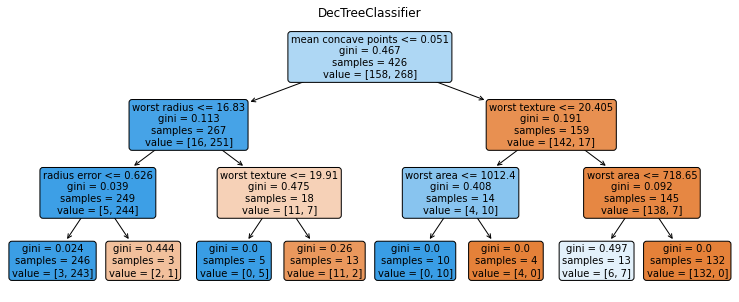

In [13]:
X, X_train, X_test = X.drop(['mean area cat'], axis = 1), X_train.drop(['mean area cat'], axis = 1), X_test.drop(['mean area cat'], axis = 1) 
plt.figure(figsize=(13, 5))
dtree = DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train.drop(['target'], axis=1), X_train['target'])
plot_tree(dtree, feature_names=X.drop(['target'], axis=1).columns, filled=True, rounded=True, fontsize=10)
plt.title('DecTreeClassifier')
plt.show()

In [16]:
prediction = dtree.predict(X_test.drop(['target'], axis=1))
print('roc auc score: {:8.2f}'.format(roc_auc_score(prediction, X_test['target'])))
print('f1 score: {:8.2f}'.format(f1_score(prediction, X_test['target'])))
print('accuracy score: {:8.2f}'.format(accuracy_score(prediction, X_test['target'])))

roc auc score:     0.95
f1 score:     0.96
accuracy score:     0.95


### Прописанное ручками дерево

In [17]:
my_dtree = DecisionTree(feature_types=df_dtr_dtypes, max_depth=3)
my_dtree.fit(X_train.drop(['target'], axis=1), X_train['target'])


In [18]:
prediction_of_my_tree = my_dtree.predict(X_test.drop(['target'], axis=1))
print('roc auc score: {:8.2f}'.format(roc_auc_score(prediction_of_my_tree, X_test['target'])))
print('f1 score: {:8.2f}'.format(f1_score(prediction_of_my_tree, X_test['target'])))
print('accuracy score: {:8.2f}'.format(accuracy_score(prediction_of_my_tree, X_test['target'])))

roc auc score:     0.96
f1 score:     0.97
accuracy score:     0.96
